# Basic linear regression

## Data processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unittest

from functions import fillna_by_time, Check_fillna_by_time
unittest.main(argv=["", "Check_fillna_by_time"], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.019s

OK


In [2]:
building_info = pd.read_csv('.\data\\building_metadata.csv')
train_meters = pd.read_csv('.\data\\train.csv')
weather_train = pd.read_csv('.\data\\weather_train.csv')

In [3]:
building_info.head(3)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN


In [4]:
# separate tasks
electricity = train_meters[train_meters.meter==0].drop('meter', axis=1)
chilledwater = train_meters[train_meters.meter==1].drop('meter', axis=1)
steam = train_meters[train_meters.meter==2].drop('meter', axis=1)
hotwater = train_meters[train_meters.meter==3].drop('meter', axis=1)

del train_meters

In [5]:
# let's start with electricity
# we should join dataframes to see the whole picture
electricity = electricity.set_index('building_id').join(
    building_info.set_index('building_id'), 
    on='building_id')
electricity.set_index(pd.Index([i for i in range(len(electricity))]), inplace=True)

In [6]:
# remove nans
electricity['floor_count'].fillna(electricity['floor_count'].median(), inplace=True)
electricity['year_built'].fillna(electricity['year_built'].median(), inplace=True)

In [7]:
for i in electricity.columns:
    part = 'has Nans!!!' if electricity[i].isna().any() else 'doesn\'t have Nans'
    print(f'column {i} {part}')

column timestamp doesn't have Nans
column meter_reading doesn't have Nans
column site_id doesn't have Nans
column primary_use doesn't have Nans
column square_feet doesn't have Nans
column year_built doesn't have Nans
column floor_count doesn't have Nans


In [8]:
print('There are', len(weather_train['site_id'].unique()), 'unique site_ids')

mean_for_site_id = 0
for i in weather_train['site_id'].unique():
    mean_for_site_id += weather_train['site_id'][weather_train['site_id'] == i].count()
mean_for_site_id /= len(weather_train['site_id'].unique())

print('But for every site_id there are in average', int(mean_for_site_id), 'rows')
print('We are going to have', int(mean_for_site_id)*len(electricity),'raws at all!!!')

There are 16 unique site_ids
But for every site_id there are in average 8735 rows
We are going to have 105352048850 raws at all!!!


In [9]:
for index in weather_train['site_id'].unique():
    testing_site_id = weather_train[weather_train['site_id'] == index]
    
    with_nans = testing_site_id['air_temperature'].isna()
    for i in testing_site_id.columns:
        with_nans |= testing_site_id[i].isna()

    print('for', index, len(testing_site_id[~with_nans])/len(testing_site_id), 
          'of data doesn\'t have Nans at all')

for 0 0.5429189435336976 of data doesn't have Nans at all
for 1 0.0 of data doesn't have Nans at all
for 2 0.6747125128088353 of data doesn't have Nans at all
for 3 0.5714123006833713 of data doesn't have Nans at all
for 4 0.4361835363770921 of data doesn't have Nans at all
for 5 0.0 of data doesn't have Nans at all
for 6 0.5867683898884081 of data doesn't have Nans at all
for 7 0.0 of data doesn't have Nans at all
for 8 0.5429189435336976 of data doesn't have Nans at all
for 9 0.44123006833712985 of data doesn't have Nans at all
for 10 0.666021407424277 of data doesn't have Nans at all
for 11 0.0 of data doesn't have Nans at all
for 12 0.0 of data doesn't have Nans at all
for 13 0.49379483092337473 of data doesn't have Nans at all
for 14 0.5924575595305913 of data doesn't have Nans at all
for 15 0.006505796072864916 of data doesn't have Nans at all


In [38]:
# research features for each site_id == 0
# drop time and site_id because they are not useful now
# (time just shows us the order to sort)
testing_site_id = weather_train[weather_train['site_id'] == 0].drop('site_id', axis=1)
for i in testing_site_id.columns[1:]:
    testing_site_id = fillna_by_time(testing_site_id, i)
testing_site_id = testing_site_id.drop('timestamp', axis=1)

testing_site_id.head(3)

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0
1,24.4,6.0,21.1,-1.0,1020.2,70.0,1.5
2,22.8,2.0,21.1,0.0,1020.2,0.0,0.0


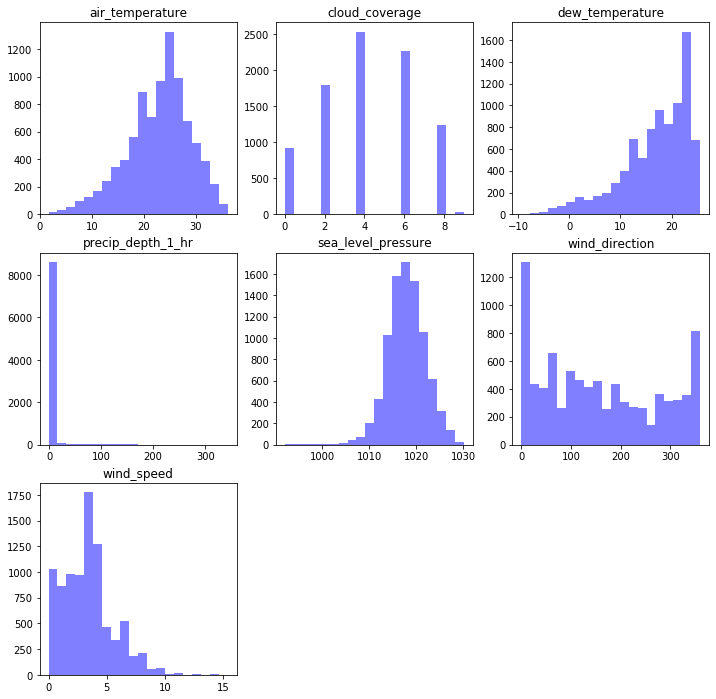

In [40]:
num_bins = 20
plt.figure(figsize=(12, 12))

index = 1
for i in testing_site_id.columns:
    plt.subplot((len(testing_site_id.columns)+2)//3, 3, index)
    plt.title(i)
    n, bins, patches = plt.hist(testing_site_id[i], num_bins, facecolor='blue', alpha=0.5)
    index += 1

plt.show()

In [48]:
# precip_depth_1_hr now doesn't have any useful info
testing_site_id = testing_site_id.drop('precip_depth_1_hr', axis=1)

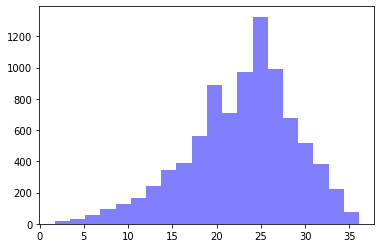

In [254]:
# let's fit normal distribution on our data
y, x, patches = plt.hist(testing_site_id['air_temperature'], num_bins, facecolor='blue', alpha=0.5)
x = np.array(x[:-1], dtype='float32')
y = np.array(y, dtype='float32')

x = ((x - x.mean())/x.max())*10
y /= y.max()

In [255]:
import tensorflow as tf
from IPython.display import clear_output

In [256]:
from tensorflow.keras import layers

class DestributionLayer(layers.Layer):
    def __init__(self, mu=0., st=1.):
        super(DestributionLayer, self).__init__()
        
        self.mu_var = mu
        self.st_var = st
        
        self.trainable = True
        
    def build(self, input_shape):
        self.mu = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.mu_var),
                             trainable=True)
        
        self.st = self.add_weight(shape=(input_shape[-1]),
                             initializer=tf.keras.initializers.Constant(self.st_var),
                             trainable=True)
        
    def call(self, inputs):
        return tf.math.exp(-(inputs - self.mu)**2 / (2*self.st)) / tf.math.sqrt(2*np.pi*self.st)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

Train on 20 samples
Epoch 1/2000
20/20 [==============================] - 0s 18ms/sample - loss: 0.4210
Epoch 2/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.3032
Epoch 3/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.2508
Epoch 4/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.2193
Epoch 5/2000
20/20 [==============================] - 0s 49us/sample - loss: 0.1979
Epoch 6/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.1822
Epoch 7/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.1702
Epoch 8/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.1606
Epoch 9/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.1528
Epoch 10/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.1462
Epoch 11/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.1405
Epoch 12/2000
20/20 [==========================

Epoch 97/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0553
Epoch 98/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0550
Epoch 99/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0547
Epoch 100/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0544
Epoch 101/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0541
Epoch 102/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0539
Epoch 103/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0536
Epoch 104/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0534
Epoch 105/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0531
Epoch 106/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0529
Epoch 107/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0526
Epoch 108/2000
20/20 [===========================

Epoch 192/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0406
Epoch 193/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0405
Epoch 194/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0404
Epoch 195/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0403
Epoch 196/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0403
Epoch 197/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0402
Epoch 198/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0401
Epoch 199/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0400
Epoch 200/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0400
Epoch 201/2000
20/20 [==============================] - 0s 99us/sample - loss: 0.0399
Epoch 202/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0398
Epoch 203/2000
20/20 [========================

Epoch 287/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0357
Epoch 288/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0357
Epoch 289/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0356
Epoch 290/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0356
Epoch 291/2000
20/20 [==============================] - 0s 99us/sample - loss: 0.0356
Epoch 292/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0355
Epoch 293/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0355
Epoch 294/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0355
Epoch 295/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0354
Epoch 296/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0354
Epoch 297/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0354
Epoch 298/2000
20/20 [========================

Epoch 382/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0333
Epoch 383/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0333
Epoch 384/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0333
Epoch 385/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0333
Epoch 386/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0332
Epoch 387/2000
20/20 [==============================] - 0s 49us/sample - loss: 0.0332
Epoch 388/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0332
Epoch 389/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0332
Epoch 390/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0332
Epoch 391/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0331
Epoch 392/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0331
Epoch 393/2000
20/20 [==========================

Epoch 477/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0318
Epoch 478/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0318
Epoch 479/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0318
Epoch 480/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0318
Epoch 481/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0318
Epoch 482/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0318
Epoch 483/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0318
Epoch 484/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0317
Epoch 485/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0317
Epoch 486/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0317
Epoch 487/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0317
Epoch 488/2000
20/20 [=======================

Epoch 572/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0308
Epoch 573/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0307
Epoch 574/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0307
Epoch 575/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0307
Epoch 576/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0307
Epoch 577/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0307
Epoch 578/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0307
Epoch 579/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0307
Epoch 580/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0307
Epoch 581/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0307
Epoch 582/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0307
Epoch 583/2000
20/20 [======================

Epoch 667/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0299
Epoch 668/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0299
Epoch 669/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0299
Epoch 670/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0299
Epoch 671/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0299
Epoch 672/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0299
Epoch 673/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0299
Epoch 674/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0298
Epoch 675/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0298
Epoch 676/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0298
Epoch 677/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0298
Epoch 678/2000
20/20 [========================

Epoch 762/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0292
Epoch 763/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0292
Epoch 764/2000
20/20 [==============================] - 0s 49us/sample - loss: 0.0292
Epoch 765/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0292
Epoch 766/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0292
Epoch 767/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0292
Epoch 768/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0291
Epoch 769/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0291
Epoch 770/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0291
Epoch 771/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0291
Epoch 772/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0291
Epoch 773/2000
20/20 [=======================

Epoch 857/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0285
Epoch 858/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0285
Epoch 859/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0285
Epoch 860/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0285
Epoch 861/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0285
Epoch 862/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0285
Epoch 863/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0285
Epoch 864/2000
20/20 [==============================] - 0s 49us/sample - loss: 0.0285
Epoch 865/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0285
Epoch 866/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0285
Epoch 867/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0285
Epoch 868/2000
20/20 [==========================

Epoch 952/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0280
Epoch 953/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0280
Epoch 954/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0280
Epoch 955/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0279
Epoch 956/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0279
Epoch 957/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0279
Epoch 958/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0279
Epoch 959/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0279
Epoch 960/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0279
Epoch 961/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0279
Epoch 962/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0279
Epoch 963/2000
20/20 [========================

Epoch 1046/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0274
Epoch 1047/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1048/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1049/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1050/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1051/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1052/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1053/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0274
Epoch 1054/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0274
Epoch 1055/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1056/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0274
Epoch 1057/2000
20/20 [===========

Epoch 1140/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0269
Epoch 1141/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0269
Epoch 1142/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0269
Epoch 1143/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0269
Epoch 1144/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0269
Epoch 1145/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0269
Epoch 1146/2000
20/20 [==============================] - 0s 99us/sample - loss: 0.0269
Epoch 1147/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0269
Epoch 1148/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0269
Epoch 1149/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0269
Epoch 1150/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0268
Epoch 1151/2000
20/20 [===========

Epoch 1234/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1235/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1236/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1237/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1238/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1239/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0264
Epoch 1240/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1241/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0264
Epoch 1242/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0264
Epoch 1243/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0263
Epoch 1244/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0263
Epoch 1245/2000
20/20 [============

Epoch 1328/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0259
Epoch 1329/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0259
Epoch 1330/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0259
Epoch 1331/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0259
Epoch 1332/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0259
Epoch 1333/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0259
Epoch 1334/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0259
Epoch 1335/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0259
Epoch 1336/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0259
Epoch 1337/2000
20/20 [==============================] - 0s 99us/sample - loss: 0.0258
Epoch 1338/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0258
Epoch 1339/2000
20/20 [===============

Epoch 1422/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0254
Epoch 1423/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0254
Epoch 1424/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0254
Epoch 1425/2000
20/20 [==============================] - 0s 99us/sample - loss: 0.0254
Epoch 1426/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0254
Epoch 1427/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0254
Epoch 1428/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0254
Epoch 1429/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0254
Epoch 1430/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0254
Epoch 1431/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0254
Epoch 1432/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0253
Epoch 1433/2000
20/20 [=============

Epoch 1516/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0249
Epoch 1517/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0249
Epoch 1518/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0249
Epoch 1519/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0249
Epoch 1520/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0249
Epoch 1521/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0249
Epoch 1522/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0249
Epoch 1523/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0249
Epoch 1524/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0249
Epoch 1525/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0249
Epoch 1526/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0249
Epoch 1527/2000
20/20 [=============

Epoch 1610/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0244
Epoch 1611/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1612/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1613/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1614/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1615/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1616/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0244
Epoch 1617/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1618/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1619/2000
20/20 [==============================] - 0s 150us/sample - loss: 0.0244
Epoch 1620/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0244
Epoch 1621/2000
20/20 [===========

Epoch 1704/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1705/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1706/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1707/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1708/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1709/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1710/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1711/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1712/2000
20/20 [==============================] - 0s 151us/sample - loss: 0.0239
Epoch 1713/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0239
Epoch 1714/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0239
Epoch 1715/2000
20/20 [==========

Epoch 1798/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0234
Epoch 1799/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0234
Epoch 1800/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0234
Epoch 1801/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0234
Epoch 1802/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0234
Epoch 1803/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0234
Epoch 1804/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0234
Epoch 1805/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0234
Epoch 1806/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0234
Epoch 1807/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0233
Epoch 1808/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0233
Epoch 1809/2000
20/20 [============

Epoch 1892/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0229
Epoch 1893/2000
20/20 [==============================] - 0s 151us/sample - loss: 0.0229
Epoch 1894/2000
20/20 [==============================] - 0s 99us/sample - loss: 0.0229
Epoch 1895/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0229
Epoch 1896/2000
20/20 [==============================] - 0s 101us/sample - loss: 0.0229
Epoch 1897/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0229
Epoch 1898/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0229
Epoch 1899/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0228
Epoch 1900/2000
20/20 [==============================] - 0s 149us/sample - loss: 0.0228
Epoch 1901/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0228
Epoch 1902/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0228
Epoch 1903/2000
20/20 [============

Epoch 1986/2000
20/20 [==============================] - 0s 48us/sample - loss: 0.0224
Epoch 1987/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0224
Epoch 1988/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0224
Epoch 1989/2000
20/20 [==============================] - 0s 98us/sample - loss: 0.0224
Epoch 1990/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0223
Epoch 1991/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0223
Epoch 1992/2000
20/20 [==============================] - 0s 49us/sample - loss: 0.0223
Epoch 1993/2000
20/20 [==============================] - 0s 50us/sample - loss: 0.0223
Epoch 1994/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0223
Epoch 1995/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0223
Epoch 1996/2000
20/20 [==============================] - 0s 100us/sample - loss: 0.0223
Epoch 1997/2000
20/20 [==============

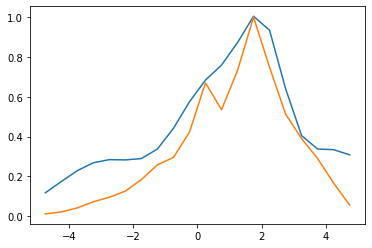

In [262]:
def loss(y, y_pred):
    return tf.reduce_mean((y_pred-y)**2)
def maxis(y):
    return tf.reduce_max(y)
    
inputs_ = layers.Input((1,))
sp = []
for i in range(5):
    sp.append(DestributionLayer((np.random.rand(1)*2-1)*2, 0.1)(inputs_))
predictions = sum(sp)

model = tf.keras.Model(
        inputs=inputs_, 
        outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(0.2),
              loss=loss)

model.fit(x, y, batch_size=len(x), epochs=2000)
plt.plot(x, model(x))
plt.plot(x, y)
plt.show()

In [253]:
model.weights

[<tf.Variable 'destribution_layer_113/Variable:0' shape=(1,) dtype=float32, numpy=array([2.8145936], dtype=float32)>,
 <tf.Variable 'destribution_layer_113/Variable:0' shape=(1,) dtype=float32, numpy=array([1.9091879], dtype=float32)>,
 <tf.Variable 'destribution_layer_114/Variable:0' shape=(1,) dtype=float32, numpy=array([2.1586425], dtype=float32)>,
 <tf.Variable 'destribution_layer_114/Variable:0' shape=(1,) dtype=float32, numpy=array([1.778012], dtype=float32)>,
 <tf.Variable 'destribution_layer_115/Variable:0' shape=(1,) dtype=float32, numpy=array([-1.4828129], dtype=float32)>,
 <tf.Variable 'destribution_layer_115/Variable:0' shape=(1,) dtype=float32, numpy=array([2.2653313], dtype=float32)>,
 <tf.Variable 'destribution_layer_116/Variable:0' shape=(1,) dtype=float32, numpy=array([1.6971184], dtype=float32)>,
 <tf.Variable 'destribution_layer_116/Variable:0' shape=(1,) dtype=float32, numpy=array([1.6257067], dtype=float32)>,
 <tf.Variable 'destribution_layer_117/Variable:0' shape=

In [ ]:
# we have a distribution layer
# so, we can simulate any distribution using stacking of this layer

In [ ]:
# our regression should understand where to put zeros